In [1]:
%matplotlib inline

In [2]:
#
# We need a regression model for predicting PDR (highest priority): 
# Variables are: 
#   - Number of unique CpGs per cell
#   - Median Average Read CpG per cell (or mean if normally distributed)
#   - BS rate per cell
#   - CLL or Normal status per cell
# What is the coefficient and the P value for each variable for a model predicting PDR?

In [3]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
pd.set_option('display.max_columns', 50) # print all rows


import os
os.chdir('/Users/evanbiederstedt/Downloads/RRBS_data_files')

In [4]:
normal_cellA_df = pd.read_csv("Meth_PDR_cell_RRBS_normal_B1.csv")
normal_cellB_df = pd.read_csv("Meth_PDR_cell_normalpcell.csv")
normal_cellC_df = pd.read_csv("Meth_PDR_cell_normal_mcell.csv")
cll_cellA_df = pd.read_csv("Meth_PDR_cell_CLL_RRBS_cw154_A.csv")
cll_cellC_df = pd.read_csv("Meth_PDR_cell_CLL_RRBS_trito_pool_C.csv")

In [5]:
normal_cellA_df = normal_cellA_df.drop(["Unnamed: 0"], axis=1)  
normal_cellA_df["type"] = str('normal')
normal_cellA_df["bio"] = str('normal_B')
normal_cellA_df["protocol"] = normal_cellA_df["filename"].str[5:24]
normal_cellA_df["filename"] = normal_cellA_df["filename"].str[:40]

In [6]:
cpg1 = pd.read_csv('Meth_PDR_cell_RRBS_normal_B1_CpGs.csv')
cpg1 = cpg1.drop(["Unnamed: 0"], axis=1)  
cpg1["filename"] = cpg1["filename"].str[:40]
normal_cellA_df = pd.merge(normal_cellA_df, cpg1, how='inner')
normal_cellB_df["type"] = str('normal')
normal_cellB_df = normal_cellB_df.drop(["Unnamed: 0"], axis=1) 
normal_cellB_df["bio"] = str('CD27p')
normal_cellB_df["protocol"] = normal_cellB_df["filename"].str[5:31]
normal_cellB_df["filename"] = normal_cellB_df["filename"].str[:50]
normal_cellB_df["filename"] = normal_cellB_df["filename"].str.replace(r'.dan$', '')
normal_cellB_df["filename"] = normal_cellB_df["filename"].str.replace(r'.da$', '')
cpg2 = pd.read_csv('RRBS_NormalBCD19pCD27pcell_CpGs.csv')
cpg2 = cpg2.drop(["Unnamed: 0"], axis=1)  
cpg2["filename"] = cpg2["filename"].str[:50]
cpg2["filename"] = cpg2["filename"].str.replace(r'.dan$', '')
cpg2["filename"] = cpg2["filename"].str.replace(r'.da$', '')
normal_cellB_df = pd.merge(normal_cellB_df, cpg2, how='inner')
normal_cellC_df = normal_cellC_df.drop(["Unnamed: 0"], axis=1)  
normal_cellC_df["type"] = str('normal')
normal_cellC_df["protocol"] = normal_cellC_df["filename"].str[5:31]
normal_cellC_df["bio"] = str('CD27m')
normal_cellC_df["filename"] = normal_cellC_df["filename"].str[:50]
normal_cellC_df["filename"] = normal_cellC_df["filename"].str.replace(r'.dan$', '')
normal_cellC_df["filename"] = normal_cellC_df["filename"].str.replace(r'.da$', '')
cpg3 = pd.read_csv("RRBS_NormalBCD19pCD27mcell_CpGs.csv")
cpg3 = cpg3.drop(["Unnamed: 0"], axis=1)  
cpg3["filename"] = cpg3["filename"].str[:50]
cpg3["filename"] = cpg3["filename"].str.replace(r'.dan$', '')
cpg3["filename"] = cpg3["filename"].str.replace(r'.da$', '')
normal_cellC_df = pd.merge(normal_cellC_df, cpg3, how='inner')
frames3 = [normal_cellA_df, normal_cellB_df, normal_cellC_df]
normal_result = pd.concat(frames3)
print(normal_result.shape)
print(normal_result.columns)

(304, 11)
Index(['PDR_total', 'avgReadCpGs_mean', 'avgReadCpGs_median', 'bio',
       'filename', 'methylation', 'mixedReadCount', 'protocol', 'thisMeth',
       'total_reads', 'type'],
      dtype='object')


In [7]:
normal_result = normal_result[['filename', 'PDR_total', 'total_reads', 'type', 'bio', 'protocol', 'avgReadCpGs_mean', 'avgReadCpGs_median']]

In [8]:
cll_cellA_df = cll_cellA_df.drop(["Unnamed: 0"], axis=1) 
cll_cellA_df["type"] = str('CLL')
cll_cellA_df["protocol"] = cll_cellA_df["filename"].str[5:34]
cll_cellA_df["protocol"][cll_cellA_df["protocol"] == 'cw154_CutSmart_proteinase_K_T'] = 'cw154_CutSmart_proteinase_K'
cll_cellA_df["protocol"][cll_cellA_df["protocol"] == 'cw154_Tris_protease_GR_CAGAGA'] = 'cw154_Tris_protease_GR'
cll_cellA_df["protocol"][(cll_cellA_df["protocol"] != 
        'cw154_Tris_protease_GR') & (cll_cellA_df["protocol"] != 'cw154_CutSmart_proteinase_K')] = 'cw154_Tris_protease'
cll_cellA_df["bio"] = str('CLL')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str[:51]
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.da$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.annoRR$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.ann$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.dan$', '')
cpg4 = pd.read_csv('CLL_RRBS_cw154_A_CpGs.csv')
cpg4 = cpg4.drop(["Unnamed: 0"], axis=1)  
cpg4["filename"] = cpg4["filename"].str[:51]
cpg4["filename"] = cpg4["filename"].str.replace(r'.da$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.annoRR$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.ann$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.dan$', '')
cll_cellA_df = pd.merge(cll_cellA_df, cpg4, how='inner')
cll_cellC_df = cll_cellC_df.drop(["Unnamed: 0"], axis=1) 
cll_cellC_df["type"] = str('CLL')
cll_cellC_df["bio"] = str('CLL')
cll_cellC_df["protocol"] = cll_cellC_df["filename"].str[5:17]
cll_cellC_df["filename"] = cll_cellC_df["filename"].str[:33]
cpg5 = pd.read_csv('Meth_PDR_cell_RRBS_trito_pool_CpGs.csv')
cpg5 = cpg5.drop(["Unnamed: 0"], axis=1) 
cpg5["filename"] = cpg5["filename"].str[:33]
cll_cellC_df = pd.merge(cll_cellC_df, cpg5, how='inner')
frames2 = [cll_cellA_df, cll_cellC_df]
cll_result = pd.concat(frames2)
print(cll_result.shape)
print(cll_result.columns)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(110, 11)
Index(['PDR_total', 'avgReadCpGs_mean', 'avgReadCpGs_median', 'bio',
       'filename', 'methylation', 'mixedReadCount', 'protocol', 'thisMeth',
       'total_reads', 'type'],
      dtype='object')


In [9]:
cll_result = cll_result[['filename', 'PDR_total', 'total_reads', 'type', 'bio', 'protocol', 'avgReadCpGs_mean', 'avgReadCpGs_median']]
cll_result = cll_result.reset_index(drop=True)
normal_result = normal_result.reset_index(drop=True)
combined2 = normal_result.append(cll_result)
combined2 = combined2.reset_index(drop=True)
combined2.head()

,filename,PDR_total,total_reads,type,bio,protocol,avgReadCpGs_mean,avgReadCpGs_median
0,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACAACC,0.271471,1954240.0,normal,normal_B,normal_B_cell_A1_24,5.295301,4.0
1,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACCGCG,0.435593,607531.0,normal,normal_B,normal_B_cell_A1_24,5.285714,4.0
2,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACGTGG,0.280063,1746403.0,normal,normal_B,normal_B_cell_A1_24,5.453122,5.0
3,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACTCAC,0.423883,2194.0,normal,normal_B,normal_B_cell_A1_24,4.950166,4.0
4,RRBS_normal_B_cell_A1_24_TAAGGCGA.AGGATG,0.253306,3584255.0,normal,normal_B,normal_B_cell_A1_24,5.366276,5.0


In [10]:
bs = pd.read_table('allStats.txt')
bs = bs.drop('sample.1', axis=1)
bs = bs.drop('sample.2', axis=1)
bs = bs.reset_index(drop=True)
bs = bs.drop('class', axis=1)
bs = bs.drop('totMeth', axis=1)
bs = bs.drop('totSeen', axis=1)
bs = bs.drop('avSum', axis=1)
bs = bs.drop('avTot', axis=1)
bs = bs.drop('rMixed', axis=1)
bs = bs.drop('rTot', axis=1)
bs = bs.drop('rAv', axis=1)
bs = bs.drop('rAvTot', axis=1)
bs = bs.drop('bed', axis=1)
bs = bs.drop('methInfoFile', axis=1)
bs = bs.drop('totReads', axis=1)
bs = bs.drop('totAligned', axis=1)
bs = bs.drop('totClipped', axis=1)
bs = bs.drop('totSeenCpG', axis=1)
bs = bs.drop('totUsed', axis=1)
bs = bs.drop('totMethCpG', axis=1)
# bs = bs.drop('totCpG', axis=1)
bs = bs.drop('totalReadPairs', axis=1)
bs = bs.drop('alignedReads', axis=1)
bs = bs.drop('totalReads', axis=1)
bs = bs.rename(columns = {'sample':'filename'})

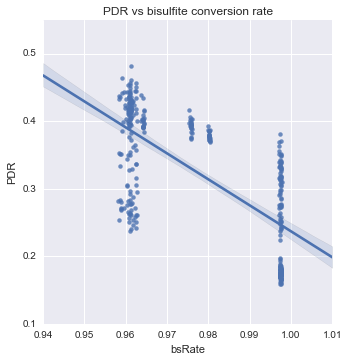

In [11]:
merged = pd.merge(combined2, bs, how='inner')
merged = merged.reset_index(drop=True)
merged = merged.rename(columns = {'PDR_total':'PDR'})
merged = merged.rename(columns = {'totCpG':'Unique_CpGs'})
# Remove all data points with less than 100k in totcpg 
merged = merged[merged['total_reads'] > 100000]
scattermatrix1 = merged.drop(['filename', 'total_reads', 'type', 'protocol', 'avgReadCpGs_median'], axis=1)
sns.lmplot(x="bsRate", y="PDR",  data=scattermatrix1)
plt.title("PDR vs bisulfite conversion rate")

In [12]:
scattermatrix7 = merged.drop(['filename', 'bio', 'avgReadCpGs_median'], axis=1)
y = scattermatrix7.PDR # dependent variable
print(y.shape)
X = scattermatrix7.drop(['PDR', 'total_reads', 'protocol'], axis=1)
print(X.shape)

categorical_variables = ['type']
for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)
    
import statsmodels.api as sm
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool1', predictPDR")
print("Variables: Number of unique CpGs per cell, mean Average Read CpG per cell, BS rate, Cll or Normal B")
est.summary()

(357,)
(357, 4)
Regression results for CLL 'RRBS_trito_pool1', predictPDR
Variables: Number of unique CpGs per cell, mean Average Read CpG per cell, BS rate, Cll or Normal B


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PDR   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     137.2
Date:                Thu, 07 Jul 2016   Prob (F-statistic):           1.61e-70
Time:                        16:58:11   Log-Likelihood:                 505.03
No. Observations:                 357   AIC:                            -1000.
Df Residuals:                     352   BIC:                            -980.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                2.7101      0.159     17.095      0.000         2.398     3.022
avgReadCpGs_mean    -0.1167      0.024     -4.868      0.000        -0.164    -0.070
Unique_CpGs       7.763e-09   1.32e-08      0.587      0.557     -1.82e-08  3.38e-08
bsRate              -3.1729      0.200    -15.836      0.000        -3.567    -2.779
type_CLL             1.3914      0.079     17.713      0.000         1.237     1.546
type_normal          1.3187      0.080     16.451      0.000         1.161     1.476
==============================================================================
Omnibus:                       53.943   Durbin-Watson:                   1.128
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.655
Skew:                           0.150   Prob(JB):                     0.000657
Kurtosis:                       2.054   Cond. No.                     8.10e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.76e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [13]:
tritopool = merged[merged["protocol"] == 'trito_pool_1']
tritopool = tritopool.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
tritopoolA = tritopool.set_index("filename")
from itertools import combinations
cc = list(combinations(tritopool.filename,2))
out = pd.DataFrame([tritopoolA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(tritopool.PDR, tritopool.PDR)), tritopool.filename, tritopool.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs = pd.merge(out, pdr_differences, how='inner')
print(pairs.shape)
pairs = pairs.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs.PDR_difference # dependent variable
X = pairs.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
print(y.shape)
print(X.shape)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool1', predict \delta PDR")
est.summary()

(210, 7)
(210,)
(210, 3)
Regression results for CLL 'RRBS_trito_pool1', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     9.359
Date:                Thu, 07 Jul 2016   Prob (F-statistic):           7.92e-06
Time:                        16:58:11   Log-Likelihood:                 819.55
No. Observations:                 210   AIC:                            -1631.
Df Residuals:                     206   BIC:                            -1618.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                4.5340      4.732      0.958      0.339        -4.795    13.863
avgReadCpGs_mean    -0.0253      0.006     -3.938      0.000        -0.038    -0.013
Unique_CpGs_mean -7.068e-09   4.46e-09     -1.584      0.115     -1.59e-08  1.73e-09
bsRate_mean         -4.4719      4.822     -0.927      0.355       -13.979     5.035
==============================================================================
Omnibus:                        9.333   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.295
Skew:                           0.475   Prob(JB):                      0.00959
Kurtosis:                       2.599   Cond. No.                     1.72e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


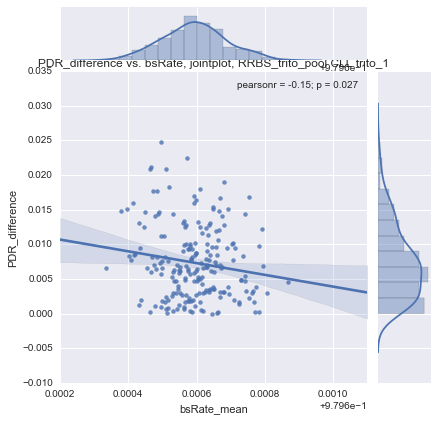

In [14]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, RRBS_trito_pool CLL trito_1")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


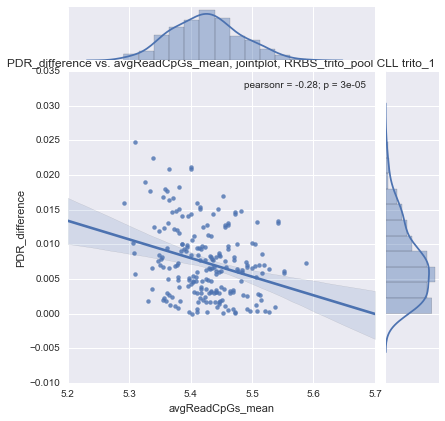

In [15]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, RRBS_trito_pool CLL trito_1")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


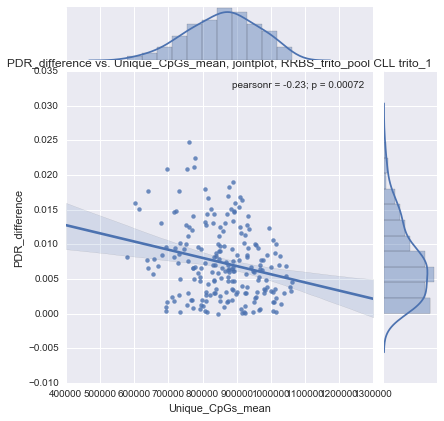

In [16]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, RRBS_trito_pool CLL trito_1")

In [17]:
tritopool2 = merged[merged["protocol"] == 'trito_pool_2']
tritopool2 = tritopool2.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
tritopool2A = tritopool2.set_index("filename")
from itertools import combinations
cc = list(combinations(tritopool2.filename,2))
out = pd.DataFrame([tritopool2A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(tritopool2.PDR, tritopool2.PDR)), tritopool2.filename, tritopool2.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs1a = pd.merge(out, pdr_differences, how='inner')
print(pairs1a.shape)
pairs1a = pairs1a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs1a.PDR_difference # dependent variable
X = pairs1a.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
print(y.shape)
print(X.shape)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool_2', predict \delta PDR")
est.summary()

(253, 7)
(253,)
(253, 3)
Regression results for CLL 'RRBS_trito_pool_2', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     7.564
Date:                Thu, 07 Jul 2016   Prob (F-statistic):           7.31e-05
Time:                        16:58:14   Log-Likelihood:                 850.10
No. Observations:                 253   AIC:                            -1692.
Df Residuals:                     249   BIC:                            -1678.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               15.9966      5.194      3.080      0.002         5.768    26.226
avgReadCpGs_mean     0.0478      0.010      4.593      0.000         0.027     0.068
Unique_CpGs_mean -2.762e-09   4.31e-09     -0.640      0.523     -1.13e-08  5.74e-09
bsRate_mean        -16.6467      5.348     -3.113      0.002       -27.179    -6.114
==============================================================================
Omnibus:                       26.015   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.042
Skew:                           0.844   Prob(JB):                     1.82e-07
Kurtosis:                       3.307   Cond. No.                     1.24e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


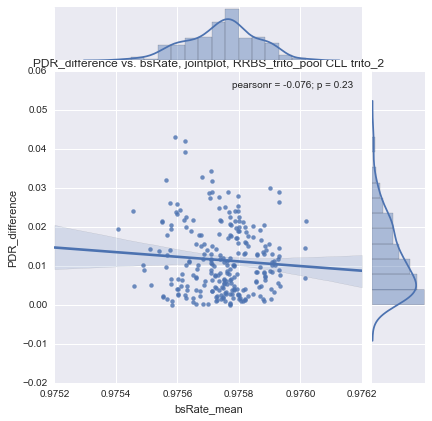

In [18]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs1a, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, RRBS_trito_pool CLL trito_2")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


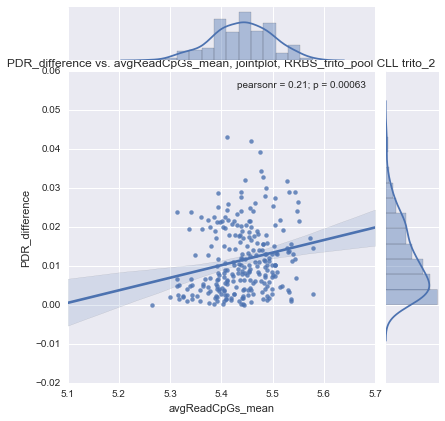

In [19]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs1a, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, RRBS_trito_pool CLL trito_2")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


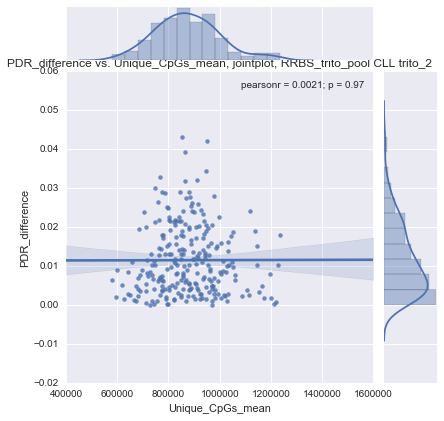

In [20]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs1a, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, RRBS_trito_pool CLL trito_2")

In [21]:
cw154 = merged[merged["protocol"] == 'cw154_Tris_protease']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.PDR, cw154.PDR)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2 = pd.merge(out, pdr_differences, how='inner')
pairs2 = pairs2.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2.PDR_difference # dependent variable
X = pairs2.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'cw154_Tris_protease', predict \delta PDR")
est.summary()

Regression results for CLL 'cw154_Tris_protease', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     7.599
Date:                Thu, 07 Jul 2016   Prob (F-statistic):           7.62e-05
Time:                        16:58:17   Log-Likelihood:                 687.17
No. Observations:                 210   AIC:                            -1366.
Df Residuals:                     206   BIC:                            -1353.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                5.4343      4.155      1.308      0.192        -2.757    13.626
avgReadCpGs_mean     0.0278      0.008      3.326      0.001         0.011     0.044
Unique_CpGs_mean -1.079e-08   5.93e-09     -1.821      0.070     -2.25e-08  8.95e-10
bsRate_mean         -5.7956      4.349     -1.333      0.184       -14.369     2.778
==============================================================================
Omnibus:                       15.543   Durbin-Watson:                   1.485
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.018
Skew:                           0.690   Prob(JB):                     0.000202
Kurtosis:                       3.198   Cond. No.                     3.92e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.92e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


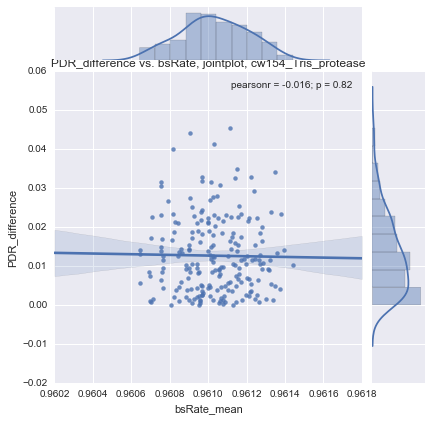

In [22]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs2, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, cw154_Tris_protease")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


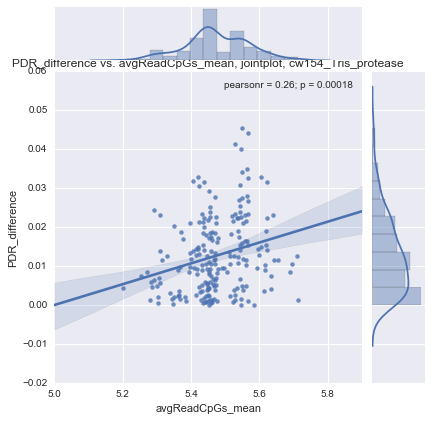

In [23]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs2, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


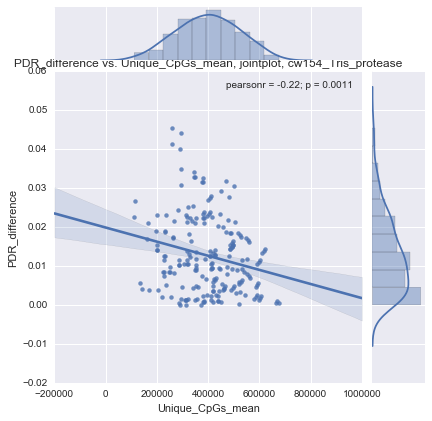

In [24]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs2, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease")

In [25]:
cw154 = merged[merged["protocol"] == 'cw154_Tris_protease_GR']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.PDR, cw154.PDR)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2a = pd.merge(out, pdr_differences, how='inner')
pairs2a = pairs2a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2a.PDR_difference # dependent variable
X = pairs2a.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_cw154_Tris_protease_GR', predict \delta PDR")
est.summary()

Regression results for CLL 'RRBS_cw154_Tris_protease_GR', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.948
Date:                Thu, 07 Jul 2016   Prob (F-statistic):              0.123
Time:                        16:58:21   Log-Likelihood:                 670.36
No. Observations:                 210   AIC:                            -1333.
Df Residuals:                     206   BIC:                            -1319.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               -1.4785      4.631     -0.319      0.750       -10.610     7.652
avgReadCpGs_mean    -0.0050      0.007     -0.674      0.501        -0.020     0.010
Unique_CpGs_mean -9.054e-09   5.28e-09     -1.716      0.088     -1.95e-08  1.35e-09
bsRate_mean          1.5861      4.842      0.328      0.744        -7.961    11.133
==============================================================================
Omnibus:                       19.567   Durbin-Watson:                   1.374
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.469
Skew:                           0.793   Prob(JB):                     1.32e-05
Kurtosis:                       3.223   Cond. No.                     5.05e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


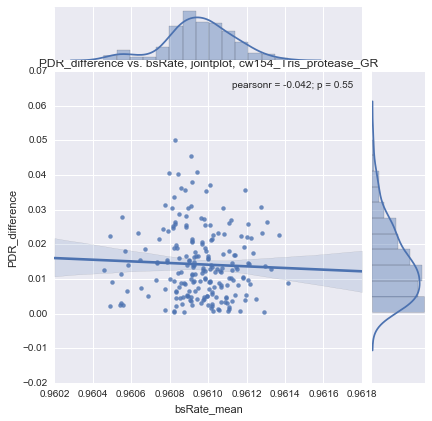

In [26]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs2a, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


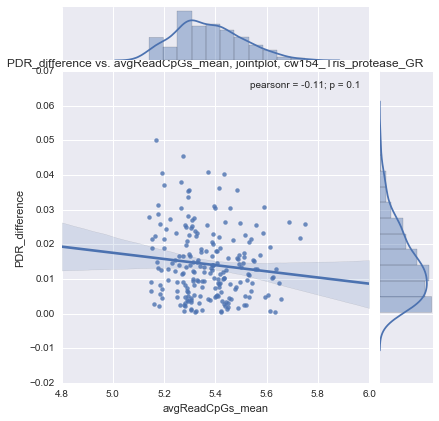

In [27]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs2a, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


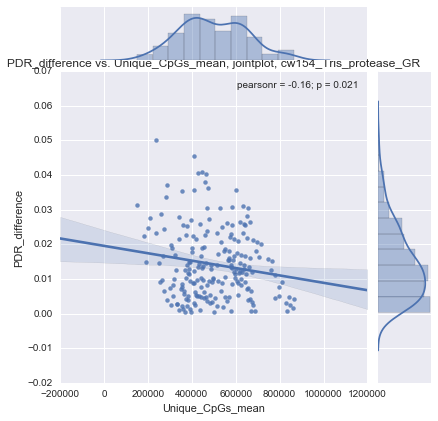

In [28]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs2a, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease_GR")

In [29]:
# cw154_CutSmart_proteinase_K
cw154 = merged[merged["protocol"] == 'cw154_CutSmart_proteinase_K']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.PDR, cw154.PDR)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2b = pd.merge(out, pdr_differences, how='inner')
pairs2b = pairs2b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2b.PDR_difference # dependent variable
X = pairs2b.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'cw154_CutSmart_proteinase_K', predict \delta PDR")
est.summary()

Regression results for CLL 'cw154_CutSmart_proteinase_K', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     13.44
Date:                Thu, 07 Jul 2016   Prob (F-statistic):           5.60e-08
Time:                        16:58:25   Log-Likelihood:                 570.14
No. Observations:                 190   AIC:                            -1132.
Df Residuals:                     186   BIC:                            -1119.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               12.2152      7.570      1.614      0.108        -2.719    27.149
avgReadCpGs_mean    -0.0716      0.020     -3.634      0.000        -0.110    -0.033
Unique_CpGs_mean -9.054e-09   9.23e-09     -0.981      0.328     -2.73e-08  9.15e-09
bsRate_mean        -12.2490      7.870     -1.556      0.121       -27.775     3.277
==============================================================================
Omnibus:                       16.804   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.864
Skew:                           0.765   Prob(JB):                     8.01e-05
Kurtosis:                       3.205   Cond. No.                     8.35e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.35e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


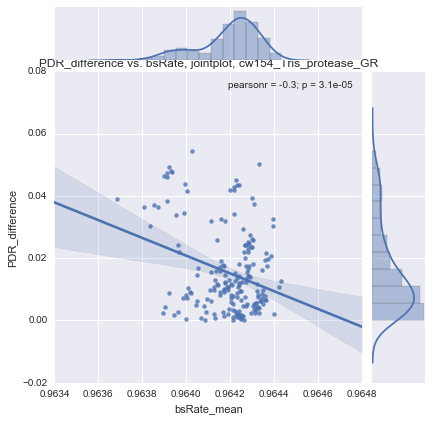

In [30]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs2b, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


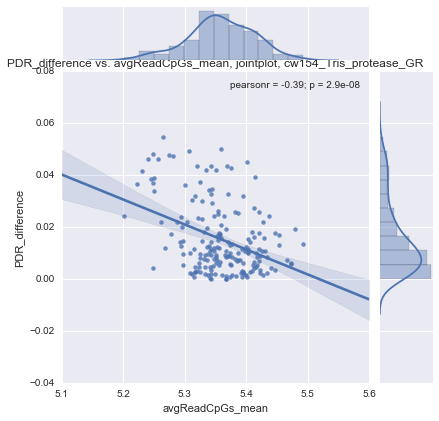

In [31]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs2b, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


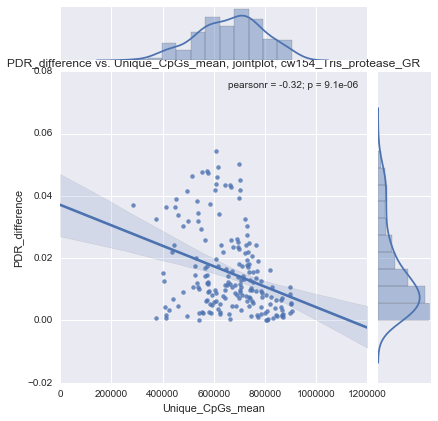

In [32]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs2b, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease_GR")

In [33]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell1_22_']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.PDR, pcell.PDR)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3 = pd.merge(out, pdr_differences, how='inner')
pairs3 = pairs3.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3.PDR_difference # dependent variable
X = pairs3.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell1_22', predict \delta PDR")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell1_22', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9154
Date:                Thu, 07 Jul 2016   Prob (F-statistic):              0.435
Time:                        16:58:28   Log-Likelihood:                 269.16
No. Observations:                 153   AIC:                            -530.3
Df Residuals:                     149   BIC:                            -518.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -28.0852     59.529     -0.472      0.638      -145.716    89.546
avgReadCpGs_mean    -0.0873      0.056     -1.550      0.123        -0.199     0.024
Unique_CpGs_mean  -2.07e-08   4.46e-08     -0.464      0.643     -1.09e-07  6.74e-08
bsRate_mean         28.6936     59.672      0.481      0.631       -89.219   146.607
==============================================================================
Omnibus:                       13.935   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.497
Skew:                           0.778   Prob(JB):                     0.000431
Kurtosis:                       3.105   Cond. No.                     9.28e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.28e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


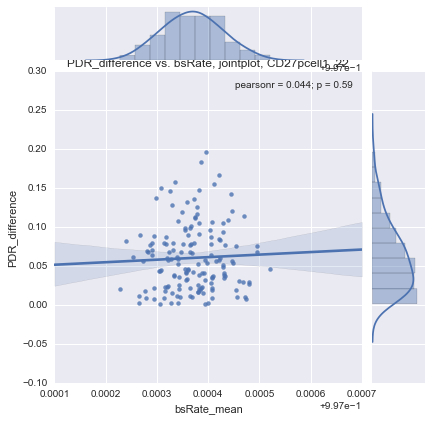

In [34]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs3, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, CD27pcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


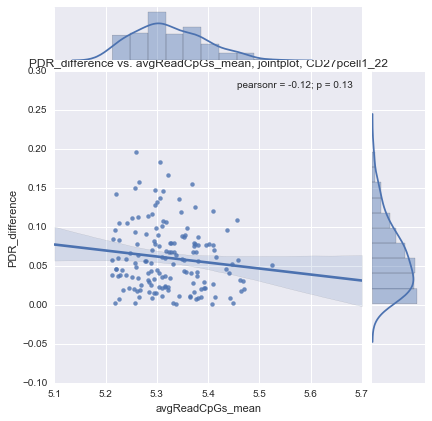

In [35]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs3, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, CD27pcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


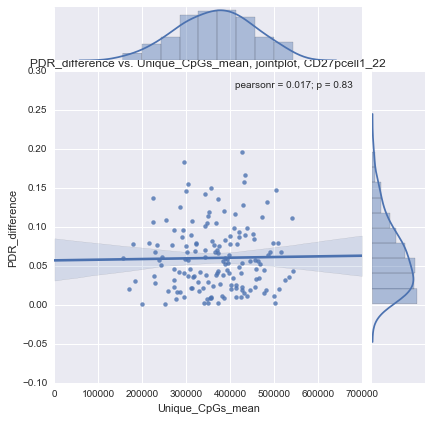

In [36]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs3, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, CD27pcell1_22")

In [37]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell23_44']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.PDR, pcell.PDR)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3a = pd.merge(out, pdr_differences, how='inner')
pairs3a = pairs3a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3a.PDR_difference # dependent variable
X = pairs3a.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell22_34', predict \delta PDR")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell22_34', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.885
Date:                Thu, 07 Jul 2016   Prob (F-statistic):              0.133
Time:                        16:58:31   Log-Likelihood:                 504.82
No. Observations:                 231   AIC:                            -1002.
Df Residuals:                     227   BIC:                            -987.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -45.9069     45.544     -1.008      0.315      -135.651    43.837
avgReadCpGs_mean     0.0452      0.023      1.943      0.053        -0.001     0.091
Unique_CpGs_mean  1.315e-08   2.77e-08      0.475      0.635     -4.14e-08  6.77e-08
bsRate_mean         45.8071     45.629      1.004      0.316       -44.104   135.719
==============================================================================
Omnibus:                       26.931   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.939
Skew:                           0.912   Prob(JB):                     7.04e-08
Kurtosis:                       3.308   Cond. No.                     1.28e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


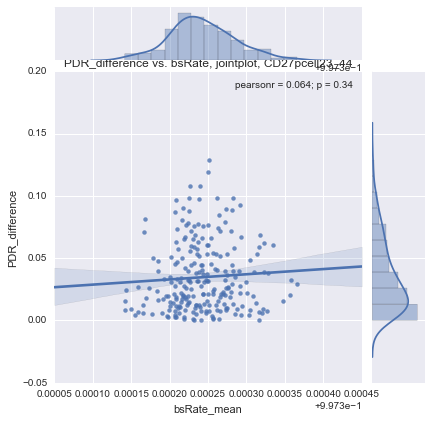

In [38]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs3a, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, CD27pcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


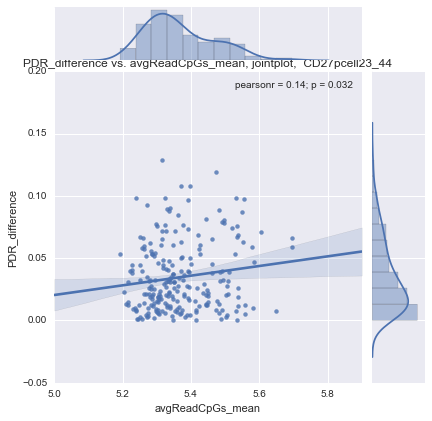

In [39]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs3a, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot,  CD27pcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


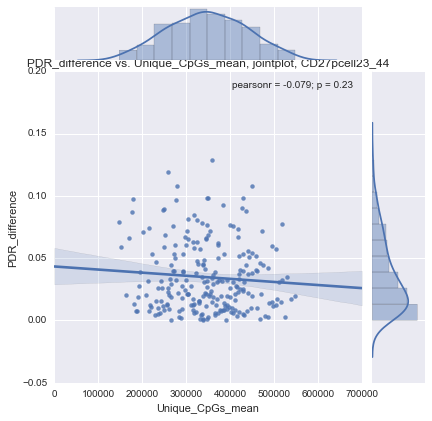

In [40]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs3a, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, CD27pcell23_44")

In [41]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell45_66']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.PDR, pcell.PDR)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3b = pd.merge(out, pdr_differences, how='inner')
pairs3b = pairs3b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3b.PDR_difference # dependent variable
X = pairs3b.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell45_66', predict \delta PDR")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell45_66', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     3.844
Date:                Thu, 07 Jul 2016   Prob (F-statistic):             0.0186
Time:                        16:58:35   Log-Likelihood:                 74.978
No. Observations:                  36   AIC:                            -142.0
Df Residuals:                      32   BIC:                            -135.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -89.6383    228.078     -0.393      0.697      -554.218   374.942
avgReadCpGs_mean     0.1388      0.078      1.779      0.085        -0.020     0.298
Unique_CpGs_mean -3.142e-08   3.23e-08     -0.973      0.338     -9.72e-08  3.44e-08
bsRate_mean         89.1745    228.326      0.391      0.699      -375.909   554.258
==============================================================================
Omnibus:                        1.483   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.476   Jarque-Bera (JB):                1.405
Skew:                           0.383   Prob(JB):                        0.495
Kurtosis:                       2.408   Cond. No.                     3.46e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.46e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


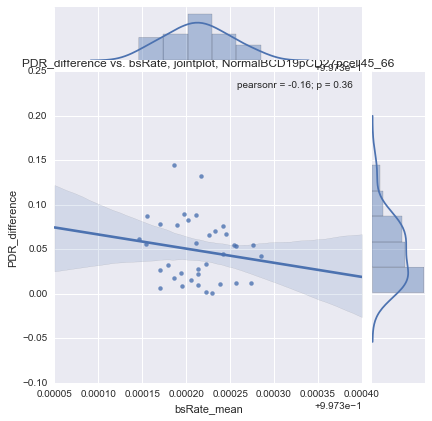

In [42]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs3b, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


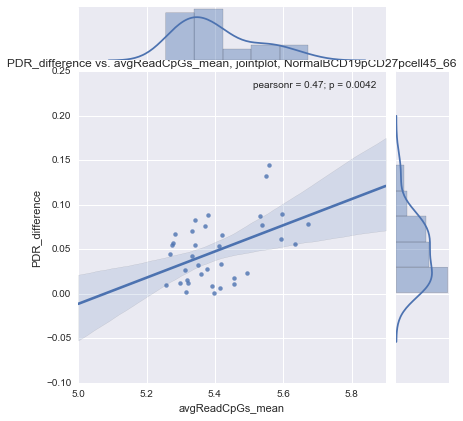

In [43]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs3b, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27pcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


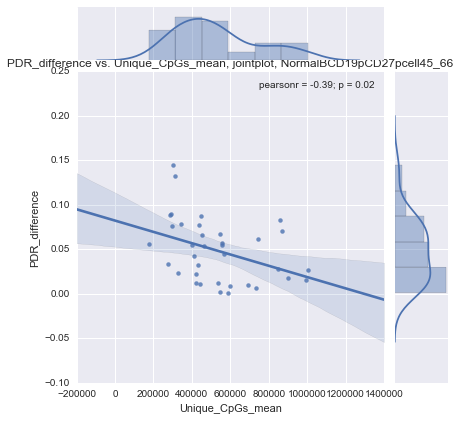

In [44]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs3b, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27pcell45_66")

In [45]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell67_88']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.PDR, pcell.PDR)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3c = pd.merge(out, pdr_differences, how='inner')
pairs3c = pairs3c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3c.PDR_difference # dependent variable
X = pairs3c.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell67_88', predict \delta PDR")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell67_88', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.535
Date:                Thu, 07 Jul 2016   Prob (F-statistic):             0.0580
Time:                        16:58:39   Log-Likelihood:                 428.58
No. Observations:                 210   AIC:                            -849.2
Df Residuals:                     206   BIC:                            -835.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               58.3227     47.361      1.231      0.220       -35.051   151.696
avgReadCpGs_mean    -0.1010      0.050     -2.027      0.044        -0.199    -0.003
Unique_CpGs_mean  4.517e-08   2.78e-08      1.624      0.106     -9.65e-09     1e-07
bsRate_mean        -57.9264     47.390     -1.222      0.223      -151.359    35.506
==============================================================================
Omnibus:                       16.911   Durbin-Watson:                   1.561
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.282
Skew:                           0.742   Prob(JB):                     6.50e-05
Kurtosis:                       3.001   Cond. No.                     1.06e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


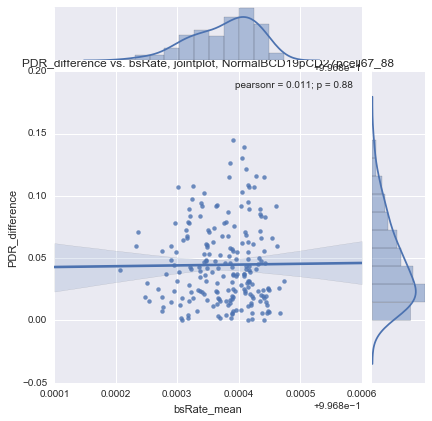

In [46]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs3c, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


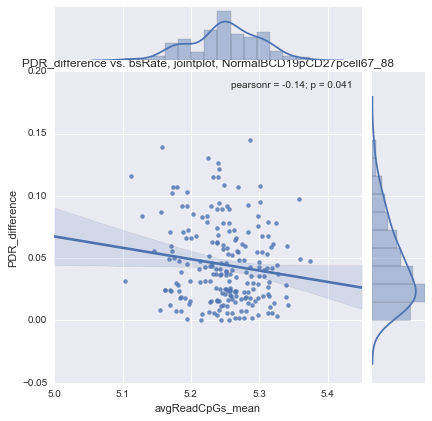

In [47]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs3c, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


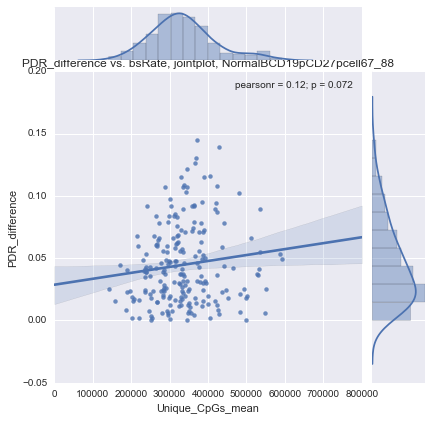

In [48]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs3c, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

In [49]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell1_22_']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.PDR, mcell.PDR)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4 = pd.merge(out, pdr_differences, how='inner')
pairs4 = pairs4.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4.PDR_difference # dependent variable
X = pairs4.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell1_22', predict \delta PDR")
est.summary()

Regression results for 'NormalBCD19pCD27mcell1_22', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     21.00
Date:                Thu, 07 Jul 2016   Prob (F-statistic):           2.10e-11
Time:                        16:58:41   Log-Likelihood:                 434.57
No. Observations:                 153   AIC:                            -861.1
Df Residuals:                     149   BIC:                            -849.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              239.5369     34.049      7.035      0.000       172.256   306.818
avgReadCpGs_mean     0.0743      0.021      3.605      0.000         0.034     0.115
Unique_CpGs_mean -3.298e-08   1.92e-08     -1.713      0.089      -7.1e-08  5.05e-09
bsRate_mean       -240.5625     34.177     -7.039      0.000      -308.096  -173.029
==============================================================================
Omnibus:                       48.215   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.505
Skew:                           1.472   Prob(JB):                     1.35e-20
Kurtosis:                       5.384   Cond. No.                     1.65e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


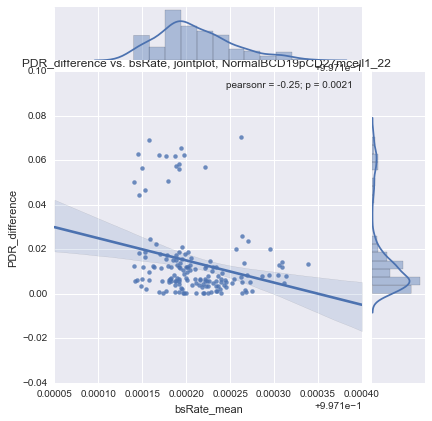

In [50]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs4, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell1_22 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


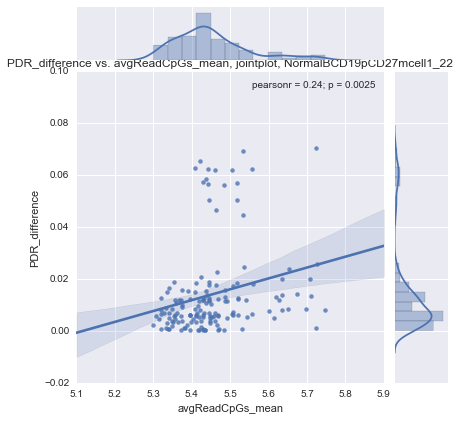

In [51]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs4, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


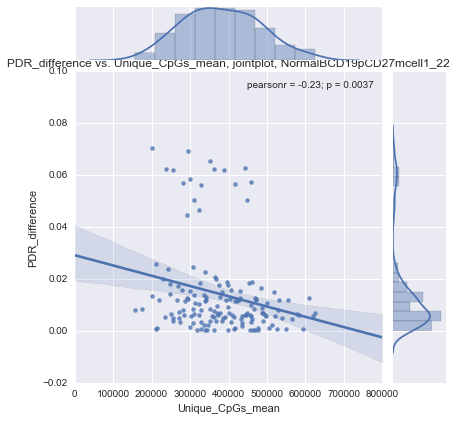

In [52]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs4, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell1_22")

In [53]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell23_44']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.PDR, mcell.PDR)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4a = pd.merge(out, pdr_differences, how='inner')
pairs4a = pairs4a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4a.PDR_difference # dependent variable
X = pairs4a.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta PDR")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     4.997
Date:                Thu, 07 Jul 2016   Prob (F-statistic):            0.00241
Time:                        16:58:45   Log-Likelihood:                 438.62
No. Observations:                 171   AIC:                            -869.2
Df Residuals:                     167   BIC:                            -856.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               13.0832     55.287      0.237      0.813       -96.069   122.235
avgReadCpGs_mean    -0.0481      0.040     -1.216      0.226        -0.126     0.030
Unique_CpGs_mean  5.067e-08   2.61e-08      1.942      0.054     -8.35e-10  1.02e-07
bsRate_mean        -12.8568     55.427     -0.232      0.817      -122.286    96.572
==============================================================================
Omnibus:                       74.640   Durbin-Watson:                   0.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.034
Skew:                           1.960   Prob(JB):                     6.61e-41
Kurtosis:                       6.255   Cond. No.                     1.91e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


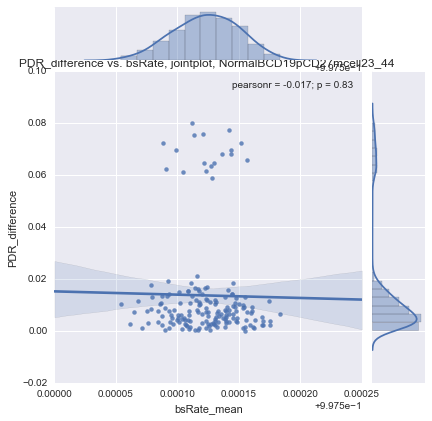

In [54]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs4a, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell23_44 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


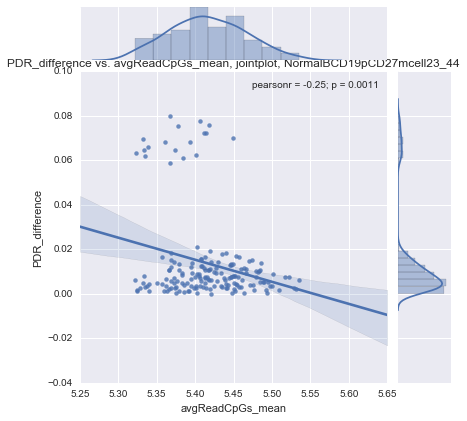

In [55]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs4a, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


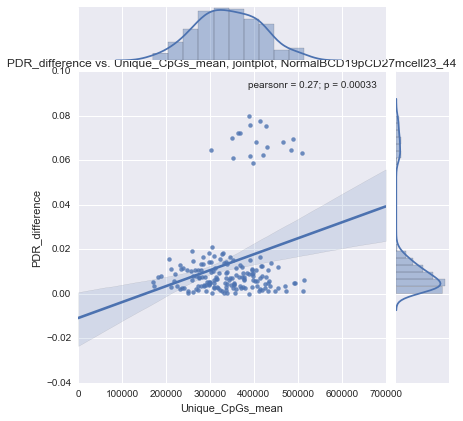

In [56]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs4a, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell23_44")

In [57]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell45_66']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.PDR, mcell.PDR)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4b = pd.merge(out, pdr_differences, how='inner')
pairs4b = pairs4b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4b.PDR_difference # dependent variable
X = pairs4b.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta PDR")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     16.79
Date:                Thu, 07 Jul 2016   Prob (F-statistic):           2.68e-09
Time:                        16:58:49   Log-Likelihood:                 502.86
No. Observations:                 136   AIC:                            -997.7
Df Residuals:                     132   BIC:                            -986.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -64.2747     15.667     -4.103      0.000       -95.266   -33.284
avgReadCpGs_mean     0.0296      0.009      3.162      0.002         0.011     0.048
Unique_CpGs_mean -4.791e-09      1e-08     -0.478      0.633     -2.46e-08   1.5e-08
bsRate_mean         64.2950     15.707      4.094      0.000        33.226    95.364
==============================================================================
Omnibus:                        3.732   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                3.609
Skew:                           0.398   Prob(JB):                        0.165
Kurtosis:                       2.946   Cond. No.                     1.55e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


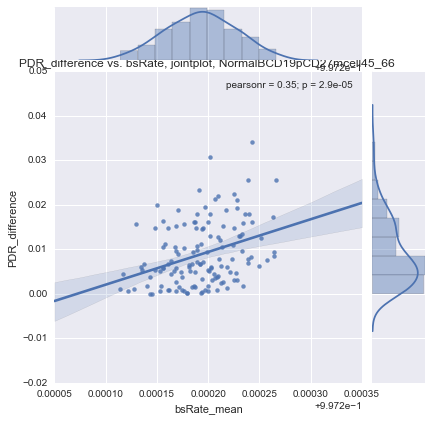

In [58]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs4b, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell45_66 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


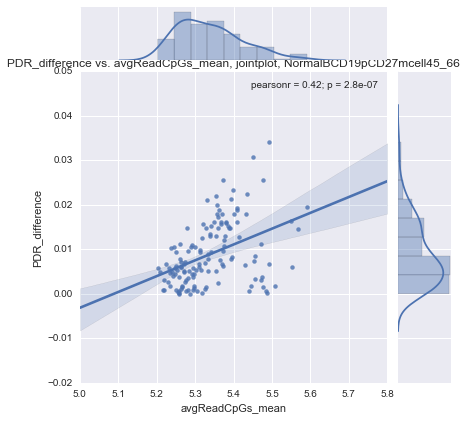

In [59]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs4b, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


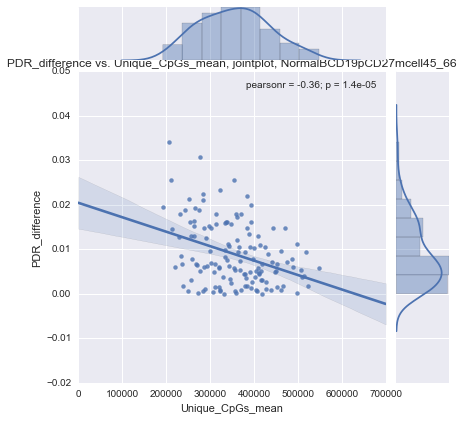

In [60]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs4b, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell45_66")

In [61]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell67_88']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.PDR, mcell.PDR)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4c = pd.merge(out, pdr_differences, how='inner')
pairs4c = pairs4c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4c.PDR_difference # dependent variable
X = pairs4c.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta PDR")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     8.738
Date:                Thu, 07 Jul 2016   Prob (F-statistic):           1.75e-05
Time:                        16:58:53   Log-Likelihood:                 549.58
No. Observations:                 210   AIC:                            -1091.
Df Residuals:                     206   BIC:                            -1078.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               63.8223     41.558      1.536      0.126       -18.111   145.755
avgReadCpGs_mean     0.0430      0.019      2.228      0.027         0.005     0.081
Unique_CpGs_mean  7.583e-08   1.84e-08      4.120      0.000      3.95e-08  1.12e-07
bsRate_mean        -64.2383     41.669     -1.542      0.125      -146.391    17.914
==============================================================================
Omnibus:                       89.857   Durbin-Watson:                   0.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.289
Skew:                           1.955   Prob(JB):                     1.80e-52
Kurtosis:                       6.457   Cond. No.                     2.04e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


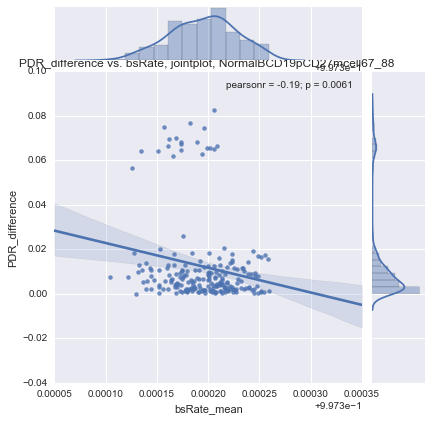

In [62]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs4c, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell67_88 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


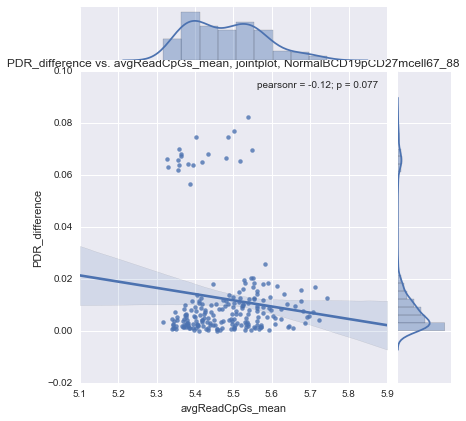

In [63]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs4c, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


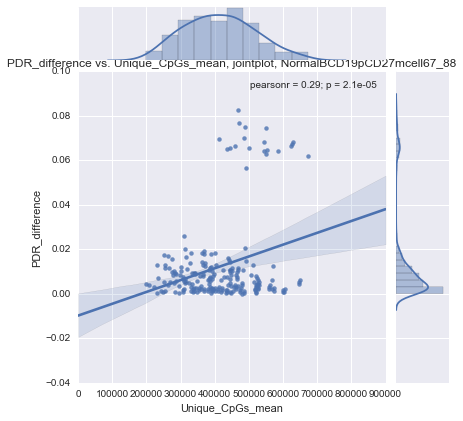

In [64]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs4c, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell67_88")

In [65]:
normb = merged[merged["protocol"] == 'normal_B_cell_A1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.PDR, normb.PDR)), normb.filename, normb.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5 = pd.merge(out, pdr_differences, how='inner')
pairs5 = pairs5.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5.PDR_difference # dependent variable
X = pairs5.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_A1_24', predict \delta PDR")
est.summary()

Regression results for 'normal_B_cell_A1_24', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.2071
Date:                Thu, 07 Jul 2016   Prob (F-statistic):              0.891
Time:                        16:58:56   Log-Likelihood:                 263.70
No. Observations:                 190   AIC:                            -519.4
Df Residuals:                     186   BIC:                            -506.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -12.0550     16.260     -0.741      0.459       -44.132    20.022
avgReadCpGs_mean    -0.0087      0.086     -0.101      0.920        -0.179     0.162
Unique_CpGs_mean  2.613e-08   1.26e-07      0.207      0.836     -2.23e-07  2.75e-07
bsRate_mean         12.7047     17.006      0.747      0.456       -20.844    46.254
==============================================================================
Omnibus:                       87.619   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.859
Skew:                           0.214   Prob(JB):                      0.00161
Kurtosis:                       1.799   Cond. No.                     1.17e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


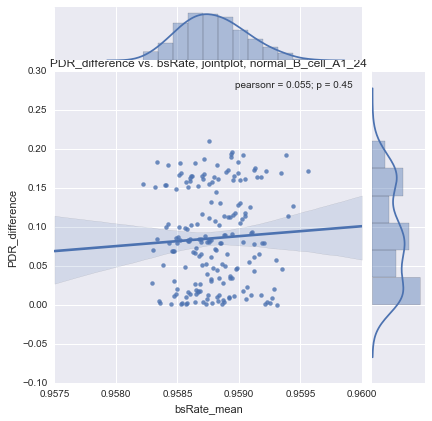

In [66]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs5, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, normal_B_cell_A1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


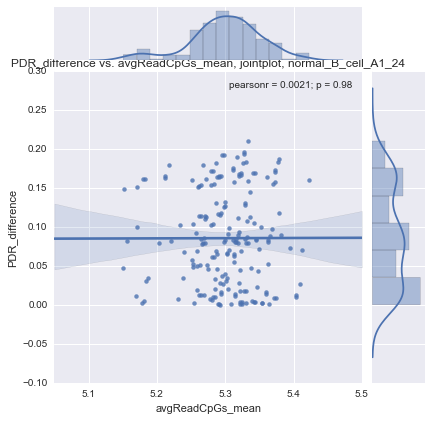

In [67]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs5, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_A1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


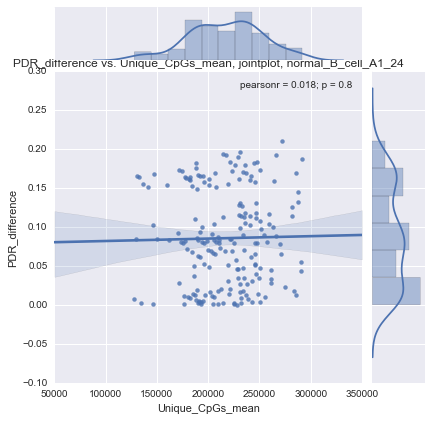

In [68]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs5, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_A1_24")

In [69]:
normb = merged[merged["protocol"] == 'normal_B_cell_B1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.PDR, normb.PDR)), normb.filename, normb.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5a = pd.merge(out, pdr_differences, how='inner')
pairs5a = pairs5a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5a.PDR_difference # dependent variable
X = pairs5a.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_B1_24', predict \delta PDR")
est.summary()

Regression results for 'normal_B_cell_B1_24', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.7567
Date:                Thu, 07 Jul 2016   Prob (F-statistic):              0.520
Time:                        16:59:00   Log-Likelihood:                 241.38
No. Observations:                 190   AIC:                            -474.8
Df Residuals:                     186   BIC:                            -461.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -42.3464     43.569     -0.972      0.332      -128.300    43.607
avgReadCpGs_mean    -0.1158      0.081     -1.433      0.153        -0.275     0.044
Unique_CpGs_mean -1.055e-09   4.56e-08     -0.023      0.982      -9.1e-08  8.89e-08
bsRate_mean         44.8076     45.622      0.982      0.327       -45.196   134.811
==============================================================================
Omnibus:                      538.791   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.350
Skew:                           0.099   Prob(JB):                     0.000282
Kurtosis:                       1.577   Cond. No.                     5.83e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


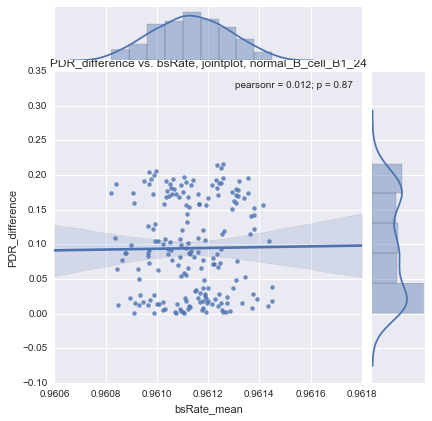

In [70]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs5a, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, normal_B_cell_B1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


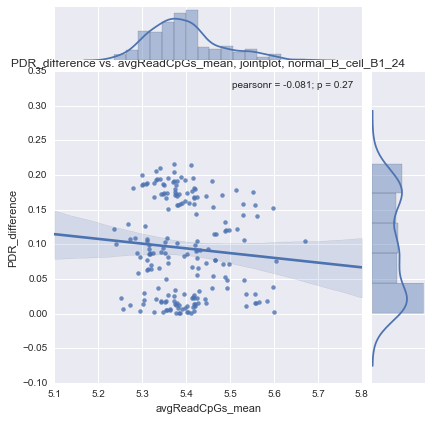

In [71]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs5a, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_B1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


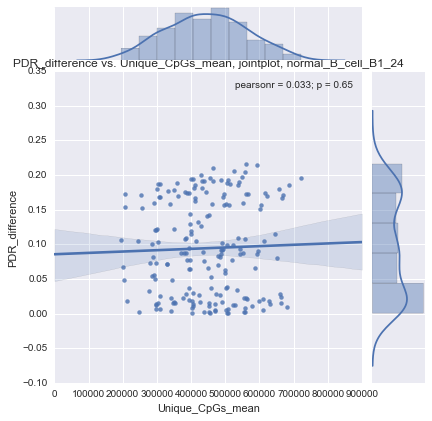

In [72]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs5a, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_B1_24")

In [73]:
normb = merged[merged["protocol"] == 'normal_B_cell_C1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.PDR, normb.PDR)), normb.filename, normb.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5b = pd.merge(out, pdr_differences, how='inner')
pairs5b = pairs5b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5b.PDR_difference # dependent variable
X = pairs5b.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_C1_24', predict \delta PDR")
est.summary()

Regression results for 'normal_B_cell_C1_24', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.1102
Date:                Thu, 07 Jul 2016   Prob (F-statistic):              0.954
Time:                        16:59:04   Log-Likelihood:                 316.05
No. Observations:                 231   AIC:                            -624.1
Df Residuals:                     227   BIC:                            -610.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               15.2657     33.782      0.452      0.652       -51.301    81.832
avgReadCpGs_mean    -0.0005      0.092     -0.005      0.996        -0.182     0.181
Unique_CpGs_mean  3.042e-09   2.03e-08      0.150      0.881     -3.69e-08   4.3e-08
bsRate_mean        -15.7677     35.408     -0.445      0.657       -85.538    54.002
==============================================================================
Omnibus:                       83.752   Durbin-Watson:                   1.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.886
Skew:                           0.298   Prob(JB):                     0.000355
Kurtosis:                       1.861   Cond. No.                     9.25e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.25e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


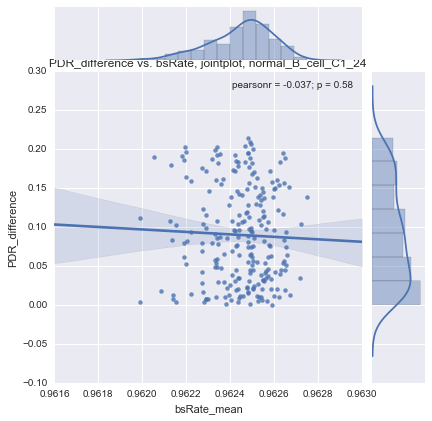

In [74]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs5b, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, normal_B_cell_C1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


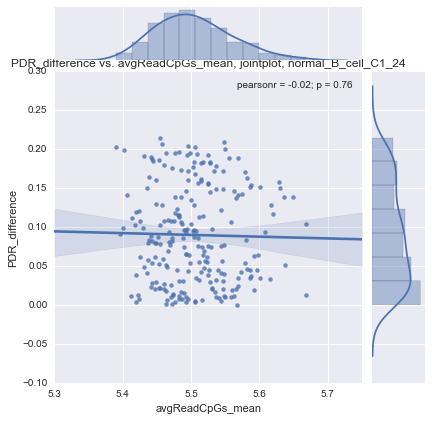

In [75]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs5b, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_C1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


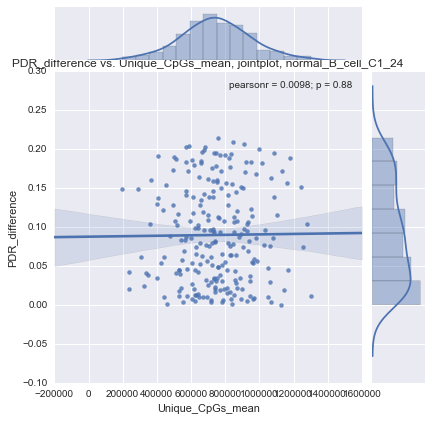

In [76]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs5b, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_C1_24")

In [77]:
normb = merged[merged["protocol"] == 'normal_B_cell_D1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.PDR, normb.PDR)), normb.filename, normb.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5c = pd.merge(out, pdr_differences, how='inner')
pairs5c = pairs5c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5c.PDR_difference # dependent variable
X = pairs5c.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_D1_24', predict \delta PDR")
est.summary()

Regression results for 'normal_B_cell_D1_24', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                 -0.049
Method:                 Least Squares   F-statistic:                    0.4503
Date:                Thu, 07 Jul 2016   Prob (F-statistic):              0.719
Time:                        16:59:07   Log-Likelihood:                 53.440
No. Observations:                  36   AIC:                            -98.88
Df Residuals:                      32   BIC:                            -92.55
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -14.7683     66.314     -0.223      0.825      -149.846   120.309
avgReadCpGs_mean    -0.1524      0.143     -1.067      0.294        -0.443     0.138
Unique_CpGs_mean  5.838e-08   6.65e-08      0.878      0.387     -7.71e-08  1.94e-07
bsRate_mean         16.2688     69.062      0.236      0.815      -124.405   156.943
==============================================================================
Omnibus:                        6.711   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                2.211
Skew:                          -0.147   Prob(JB):                        0.331
Kurtosis:                       1.822   Cond. No.                     7.43e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.43e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


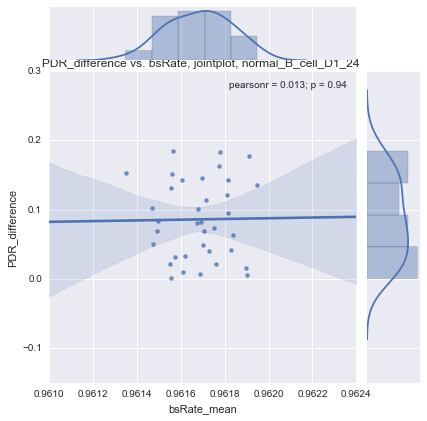

In [78]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs5c, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, normal_B_cell_D1_24 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


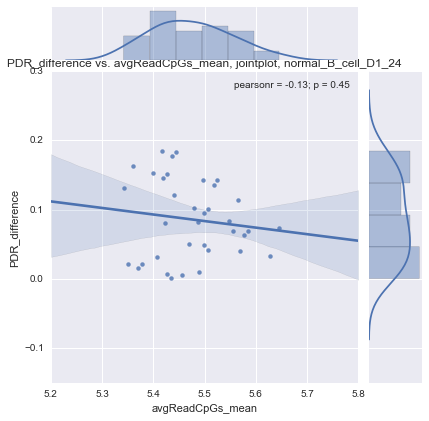

In [79]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs5c, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_D1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


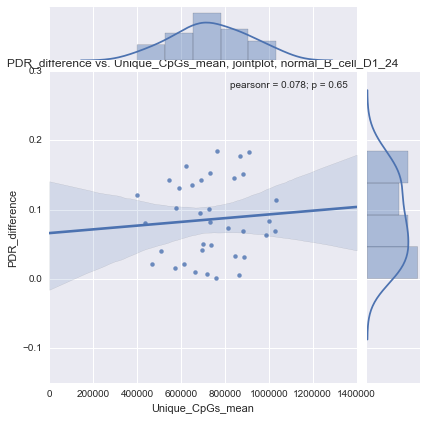

In [80]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs5c, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_D1_24")

In [81]:
normb = merged[merged["protocol"] == 'normal_B_cell_G1_22']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.PDR, normb.PDR)), normb.filename, normb.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5d = pd.merge(out, pdr_differences, how='inner')
pairs5d = pairs5d.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5d.PDR_difference # dependent variable
X = pairs5d.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_G1_22', predict \delta PDR")
est.summary()

Regression results for 'normal_B_cell_G1_22', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     3.606
Date:                Thu, 07 Jul 2016   Prob (F-statistic):             0.0147
Time:                        16:59:10   Log-Likelihood:                 254.34
No. Observations:                 171   AIC:                            -500.7
Df Residuals:                     167   BIC:                            -488.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -34.7299     25.822     -1.345      0.180       -85.709    16.249
avgReadCpGs_mean     0.1019      0.095      1.075      0.284        -0.085     0.289
Unique_CpGs_mean  1.462e-08   3.98e-08      0.367      0.714     -6.39e-08  9.32e-08
bsRate_mean         35.6636     27.189      1.312      0.191       -18.015    89.342
==============================================================================
Omnibus:                       52.614   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.468
Skew:                           0.352   Prob(JB):                      0.00196
Kurtosis:                       1.880   Cond. No.                     5.53e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


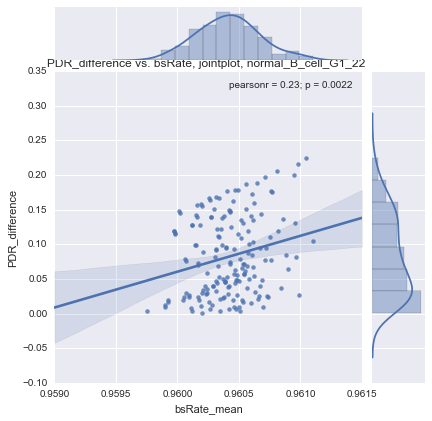

In [82]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs5d, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, normal_B_cell_G1_22 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


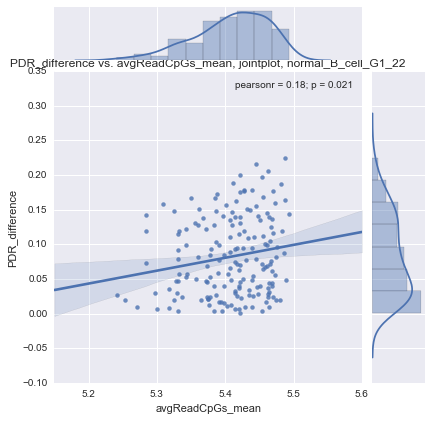

In [83]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs5d, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_G1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


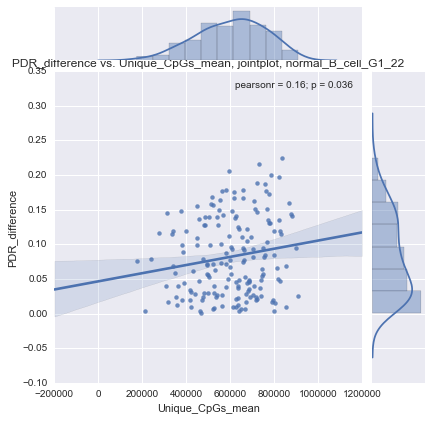

In [84]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs5d, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_G1_22")

In [85]:
normb = merged[merged["protocol"] == 'normal_B_cell_H1_22']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.PDR, normb.PDR)), normb.filename, normb.filename)
stacked = df_ex.stack()
pdr_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'PDR_difference': stacked})[['filename', 'PDR_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5e = pd.merge(out, pdr_differences, how='inner')
pairs5e = pairs5e.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5e.PDR_difference # dependent variable
X = pairs5e.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_H1_22', predict \delta PDR")
est.summary()

Regression results for 'normal_B_cell_H1_22', predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7167
Date:                Thu, 07 Jul 2016   Prob (F-statistic):              0.544
Time:                        16:59:13   Log-Likelihood:                 165.83
No. Observations:                 120   AIC:                            -323.7
Df Residuals:                     116   BIC:                            -312.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -17.8372     48.313     -0.369      0.713      -113.526    77.852
avgReadCpGs_mean    -0.1406      0.111     -1.265      0.208        -0.361     0.079
Unique_CpGs_mean  8.248e-08   6.57e-08      1.254      0.212     -4.77e-08  2.13e-07
bsRate_mean         19.3752     50.427      0.384      0.702       -80.502   119.253
==============================================================================
Omnibus:                       19.436   Durbin-Watson:                   1.187
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.489
Skew:                           0.604   Prob(JB):                      0.00320
Kurtosis:                       2.084   Cond. No.                     6.56e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.56e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


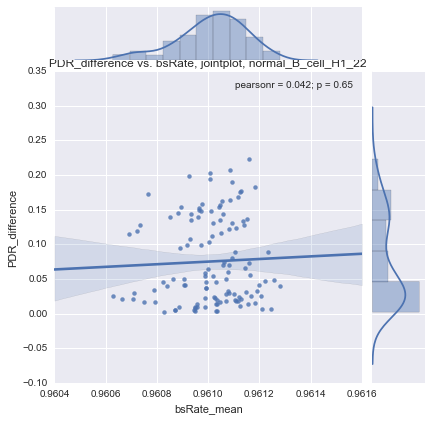

In [86]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=pairs5e, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, normal_B_cell_H1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


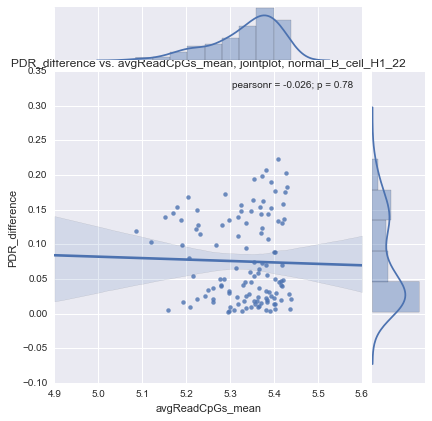

In [87]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=pairs5e, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_H1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


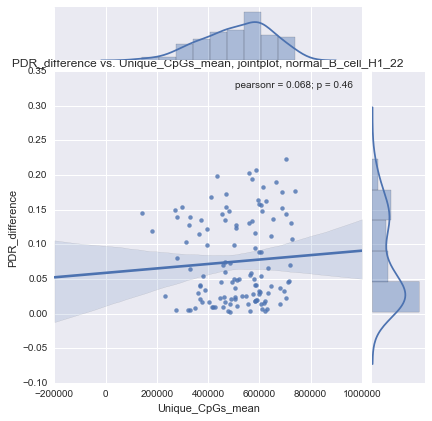

In [88]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=pairs5e, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_H1_22")

In [89]:
pairs['type'] = str('CLL')
pairs1a['type'] = str('CLL')
pairs2['type'] = str('CLL')
pairs2a['type'] = str('CLL')
pairs2b['type'] = str('CLL')
pairs3['type'] = str('CLL')
pairs3a['type'] = str('normal')
pairs3b['type'] = str('normal')
pairs3c['type'] = str('normal')
pairs4['type'] = str('normal')
pairs4a['type'] = str('normal')
pairs4b['type'] = str('normal')
pairs4c['type'] = str('normal')
pairs5['type'] = str('normal')
pairs5a['type'] = str('normal')
pairs5b['type'] = str('normal')
pairs5c['type'] = str('normal')
pairs5d['type'] = str('normal')
pairs5e['type'] = str('normal')

frames22 = [pairs, pairs2, pairs3, pairs4]
total_pairs = pd.concat(frames22)
y = total_pairs.PDR_difference # dependent variable
X = total_pairs.drop(['PDR', 'PDR_difference', 'total_reads_mean', 'filename'], axis=1)

categorical_variables = ['type']
for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)
    
X = X.drop(['type_normal'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results, all batches 'Normal B' vs 'CLL' , predict \delta PDR")
est.summary()

Regression results, all batches 'Normal B' vs 'CLL' , predict \delta PDR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PDR_difference   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     148.7
Date:                Thu, 07 Jul 2016   Prob (F-statistic):           1.08e-92
Time:                        16:59:16   Log-Likelihood:                 1743.3
No. Observations:                 726   AIC:                            -3477.
Df Residuals:                     721   BIC:                            -3454.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               -1.0292      0.115     -8.965      0.000        -1.255    -0.804
avgReadCpGs_mean    -0.0187      0.010     -1.846      0.065        -0.039     0.001
Unique_CpGs_mean -5.406e-08   3.59e-09    -15.078      0.000     -6.11e-08  -4.7e-08
bsRate_mean          1.1690      0.076     15.458      0.000         1.021     1.318
type_CLL             0.0411      0.003     15.114      0.000         0.036     0.046
==============================================================================
Omnibus:                      281.616   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1886.699
Skew:                           1.590   Prob(JB):                         0.00
Kurtosis:                      10.229   Cond. No.                     9.50e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.5e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


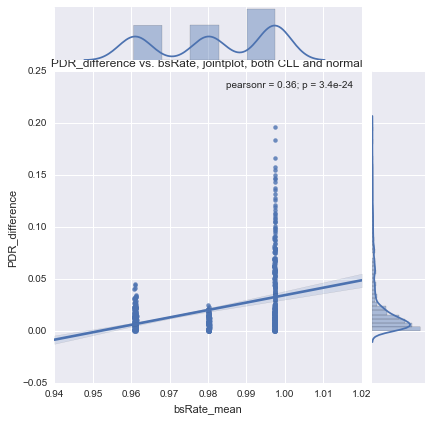

In [90]:
sns.jointplot(x="bsRate_mean", y="PDR_difference",  data=total_pairs, kind="reg")
plt.title("PDR_difference vs. bsRate, jointplot, both CLL and normal ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


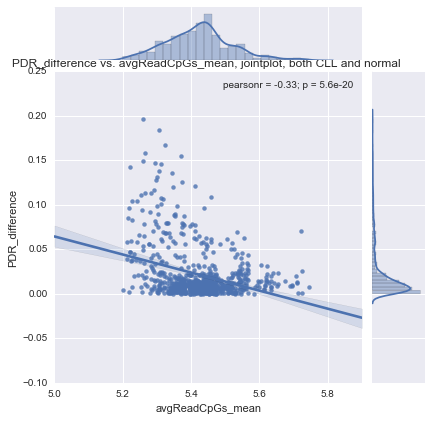

In [91]:
sns.jointplot(x="avgReadCpGs_mean", y="PDR_difference",  data=total_pairs, kind="reg")
plt.title("PDR_difference vs. avgReadCpGs_mean, jointplot, both CLL and normal ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


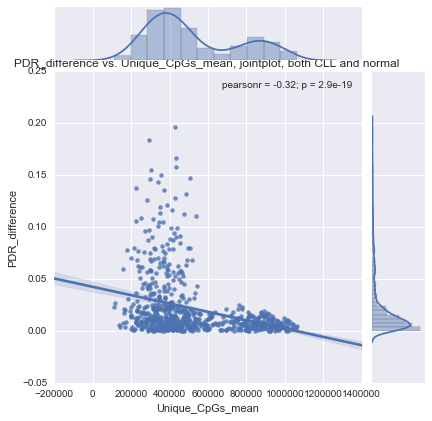

In [92]:
sns.jointplot(x="Unique_CpGs_mean", y="PDR_difference",  data=total_pairs, kind="reg")
plt.title("PDR_difference vs. Unique_CpGs_mean, jointplot, both CLL and normal ")

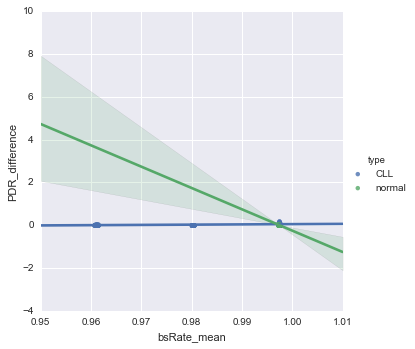

In [93]:
sns.lmplot(x="bsRate_mean", y="PDR_difference",  data=total_pairs, hue='type')

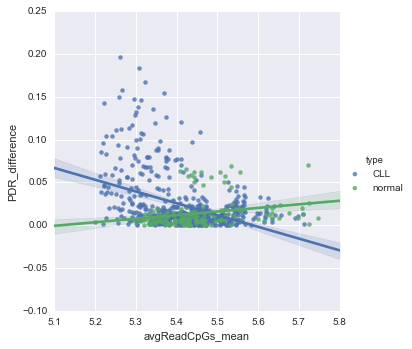

In [94]:
sns.lmplot(x="avgReadCpGs_mean", y="PDR_difference",  data=total_pairs, hue='type')

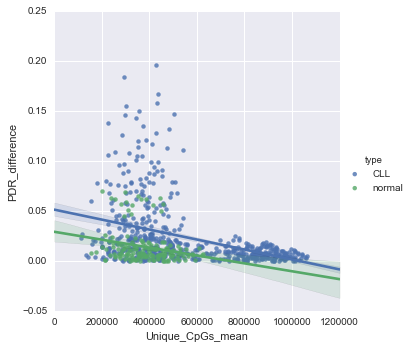

In [95]:
sns.lmplot(x="Unique_CpGs_mean", y="PDR_difference",  data=total_pairs, hue='type')

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


Random Forest model score is 0.899820280536


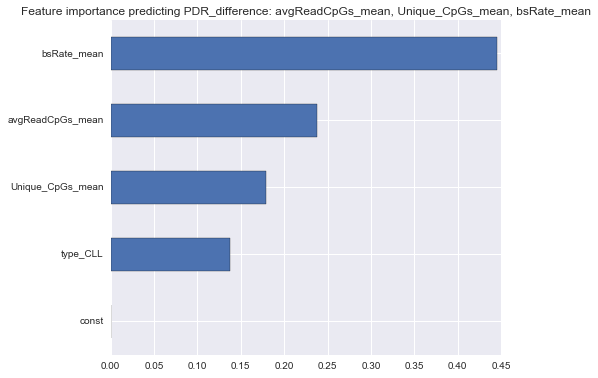

In [96]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

model = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=36)
model.fit(X, y)
# Simple version that shows all of the variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(7,6))
plt.title("Feature importance predicting PDR_difference: avgReadCpGs_mean, Unique_CpGs_mean, bsRate_mean")
print(str("Random Forest model score is ") + str(model.score(X,y)))